# 1. Problem

<div style="position:relative">
  <div style="float:right; margin:0 0 1em 1em">
    <img src="https://www.geringerart.com/wp-content/uploads/2017/07/xu-beihong-self-portrait.jpg" alt="Portrait" width="100">
  </div>
  <div style="margin-top:50px">
    <p><b>Hsü Pei-hung</b>, was primarily known for his Chinese ink paintings of horses and was one of the first Chinese artists to articulate the need for artistic expressions that reflected a modern China at the beginning of the 20th century. Chinese people are fond of his paintings so much that even now we can still see a lot of his works hanging in many places. Meanwhile we can't see more about his paintings after his death in 26 September 1953. This project is going to use Machine Learning to transfer his painting styles to normal horse pictures.</p>
    <p>Here is his biography, please click this <a href="https://www.artnet.com/artists/xu-beihong/">link</a> to see. The following is some examples of his works. </p>
    <p>

  </div>
   
</div>

   <div style="display:flex;">
  <img src="https://www.artnet.com/WebServices/images/ll02584lldQF3JFgX31E3CfDrCWQFHPKc5UjG/xu-beihong-%E5%BE%90%E6%82%B2%E9%B8%BF-1950%E5%B9%B4%E4%BD%9C-%E5%A5%94%E9%A9%AC-%E9%95%9C%E5%BF%83.jpg" style="width:50%; object-fit:contain">
  <img src="https://prabook.com/web/show-photo.jpg?id=1522246&cache=false" style="width:50%;  object-fit:contain">
</div>

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import os

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

#from psutil import virtual_memory
#ram_gb = virtual_memory().total / 1e9
#print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

#if ram_gb < 20:
#  print('Not using a high-RAM runtime')
#else:
#  print('You are using a high-RAM runtime!')

Mon May  1 02:08:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# 2. Exploratory Data Analysis

**2.1 Prepare Data, transfer from Google Drive to Google Cloud Bucket.**

I collected images from internet, and upload them into my Google drive. I find a way to transfer all the data to Kaggle from google.colab import drive. The following is the source code I used to transfer the images to the Google Cloud.

<div style="background-color: rgb(240, 240, 240);">

from google.colab import drive
    
drive.mount('/content/drive')
 
from google.colab import auth
    
auth.authenticate_user()
    
project_id = 'inkwash'
    
!gcloud config set project {project_id}
    
!gsutil ls

bucket_name = 'bkt-ink' # copy files to my bucket
    
!gsutil -m cp -r /content/drive/MyDrive/Datasets/InkWash* gs://{bucket_name}/

</div>

Make sure the bucket is public when doing this.

**2.2 Create dataset on Kaggle, import data from Google Cloud**

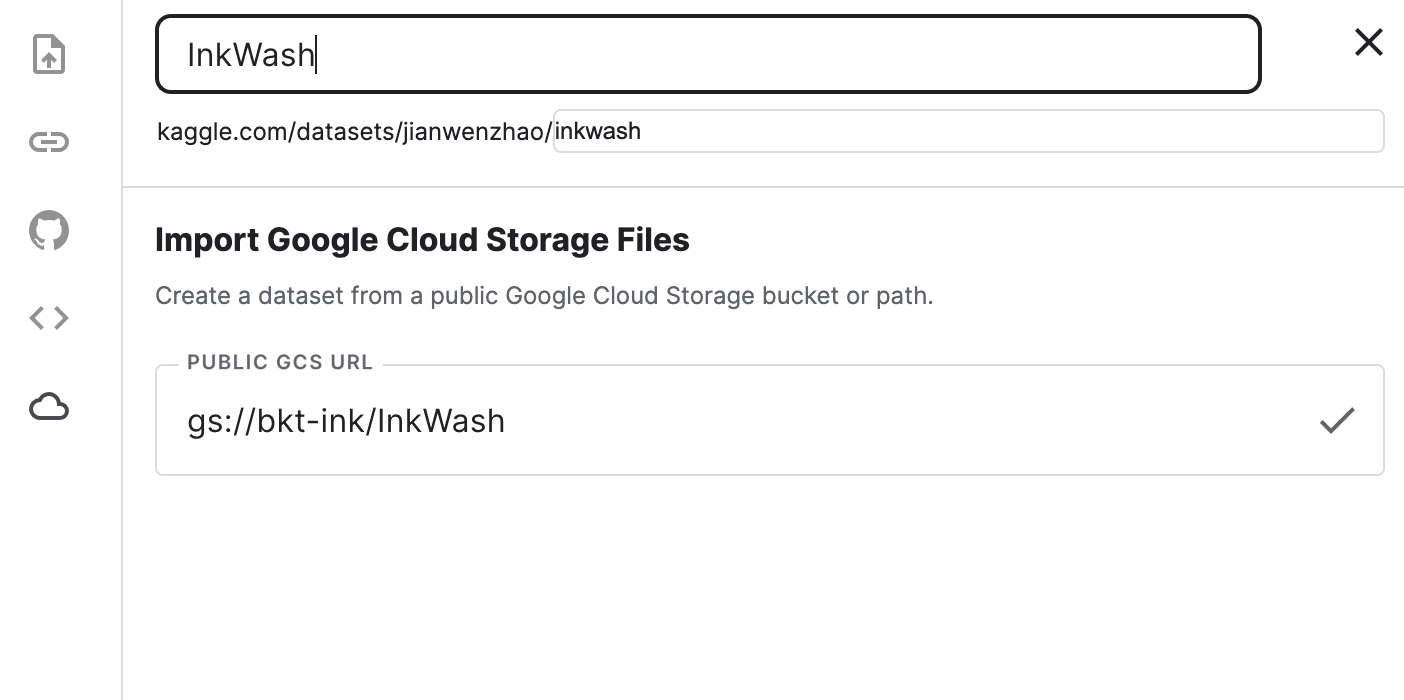


**2.1 General files information**

In [5]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from prettytable import PrettyTable

DATASET_BASE_PATH = "/kaggle/input/ink-wash/"

def list_folders(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

def count_files_and_extensions(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    extensions = {os.path.splitext(f)[1] for f in files}
    return len(files), extensions

folders = list_folders(DATASET_BASE_PATH)

table = PrettyTable()
table.field_names = ["Dataset folder", "Sub folder", "Number of files", "File type"]

for folder in folders:
    folder_path = os.path.join(DATASET_BASE_PATH, folder)
    num_files, unique_extensions = count_files_and_extensions(folder_path)
    table.add_row([DATASET_BASE_PATH, folder, num_files, ', '.join(unique_extensions)])

print(table)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

+-------------------------+------------+-----------------+-----------+
|      Dataset folder     | Sub folder | Number of files | File type |
+-------------------------+------------+-----------------+-----------+
| /kaggle/input/ink-wash/ |   testB    |        90       |    .png   |
| /kaggle/input/ink-wash/ |   testA    |       173       |    .png   |
| /kaggle/input/ink-wash/ |   trainB   |       822       |    .jpg   |
| /kaggle/input/ink-wash/ |   trainA   |       1498      |    .jpg   |
+-------------------------+------------+-----------------+-----------+


**2.2 Display 3 random images in each folder**

 Folder: testB


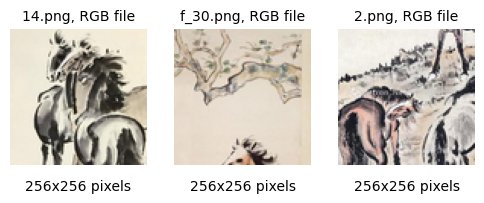

 Folder: testA


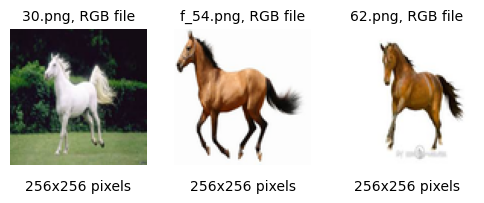

 Folder: trainB


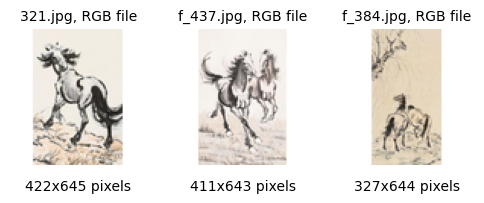

 Folder: trainA


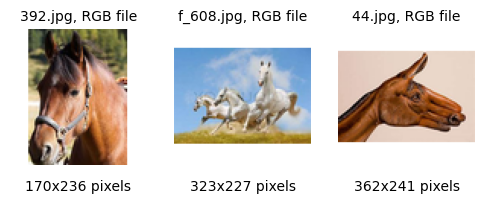

In [7]:
import random
from PIL import Image

def list_image_files(folder_path):
    return [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

frame_size = (90,90)

for folder in folders:
    folder_path = os.path.join(DATASET_BASE_PATH, folder)
    image_files = list_image_files(folder_path)
    
    # Randomly choose just 3 images
    selected_image_files = random.sample(image_files, min(len(image_files), 3))
    
    print(f"\033[1m Folder: {folder}\033[0m")

    fig, axes = plt.subplots(1, 3, figsize=(6, 2))
    for i, image_file in enumerate(selected_image_files):
        image_path = os.path.join(folder_path, image_file)
        img = Image.open(image_path)
        
        # original dimensions
        original_width, original_height = img.size
        
        # Resize the image, keep its aspect ratio
        img.thumbnail(frame_size, Image.LANCZOS)
        
        # Get channel numbers
        img_mode = img.mode
            
        # Pad to center of the frame
        padding_x = (frame_size[0] - img.size[0]) // 2
        padding_y = (frame_size[1] - img.size[1]) // 2
        
        framed_img = Image.new('RGB', frame_size, (255, 255, 255))
        framed_img.paste(img, (padding_x, padding_y))
        
        axes[i].imshow(framed_img)
        axes[i].set_title(f"{image_file}, {img_mode} file", fontsize=10, fontweight='normal')
        axes[i].axis('off')
        
        axes[i].text(0.5, -0.1, f"{original_width}x{original_height} pixels", transform=axes[i].transAxes, ha='center', va='top')

    plt.show()


We can see that all the files have 3 channels, they are **RGB** files. **The image dimensions are different in folder testA, trainB, and trainA**. The RGB files in the testB folder are 256x256 pixels, this means that the images in the testB folder were preprocessed or rescaled separately from the other images. We **need to do some resize work** before we do machine learning. By this meanings, it can improve performance and reduce memory usage. However, the specific size to which the images should be resized can depend on various factors, such as the style transfer algorithm used, the available hardware resources, and the desired balance between quality and speed.

# 3. Model Design

**3.1 Choose CycleGAN**

In 2014, Goodfellow et al. proposed an unsupervised network called GAN, which consists of a generative networkand and discriminant network. The data generated by the generative network are close to the distribution of the real data. Therefore, GAN has **better** capabilities than other networks in data generation. 

In 2016, Isola et al. proposed the pix2pix model as a representative work of image-to-image translation. This algorithm can accomplish the task of image style transfer excellently. Meanwhile it involves **a large amount of paired image data**. In reality, we don't have so many paired image datasets.

In 2017, Zhu et al. proposed an unsupervisedadversarial network of CycleGAN based on GAN to **break the limitation of pix2pix**. This network does not need to train the paired dataset and only uses the generator and the discriminator to complete the image domain conversion. So far, this CycleGAN is broadly used for style transfering.

In recent years, most style transfering task is using CycleGAN. When I made research, I also found someone is using VGG19 (19 layers). This was proposed by Visual Geometry Group of Oxford. In most cases, just like **AlexNet** and **Resnet 50**, it's better for **image classification**. **Unet** is used for image **semantic segmentation**, not for Style transfer.

Hence, we decided to use **CycleGAN network**. 

**3.2 Design of CycleGAN Network**

**3.3 Implementation of the model design**

In [101]:
class Discriminator(nn.Module):
    def __init__(self,conv_dim=32):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, conv_dim, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim, conv_dim*2, 4, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim*2, conv_dim*4, 4, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim*4, conv_dim*8, 4, padding=1),
            nn.InstanceNorm2d(conv_dim*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(conv_dim*8, 1, 4, padding=1),
        )

    def forward(self, x):
        x = self.main(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.main = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.main(x)


class Generator(nn.Module):
    def __init__(self, conv_dim=64, n_res_block=9):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, conv_dim, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(conv_dim, conv_dim*2, 3, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(conv_dim*2, conv_dim*4, 3, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*4),
            nn.ReLU(inplace=True),

            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),
            ResidualBlock(conv_dim*4),

            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(conv_dim*2, conv_dim, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(conv_dim),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(conv_dim, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class CycleGAN:

    def __init__(self, g_conv_dim=64, d_conv_dim=64, n_res_block=6):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

        self.G_XtoY = Generator(conv_dim=g_conv_dim, n_res_block=n_res_block).to(self.device)
        self.G_YtoX = Generator(conv_dim=g_conv_dim, n_res_block=n_res_block).to(self.device)

        self.D_X = Discriminator(conv_dim=d_conv_dim).to(self.device)
        self.D_Y = Discriminator(conv_dim=d_conv_dim).to(self.device)

        print(f"Models running of {self.device}")

    def load_model(self, filename):
        save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
        return torch.load(save_filename)

    def real_mse_loss(self, D_out):
        return torch.mean((D_out-1)**2)


    def fake_mse_loss(self, D_out):
        return torch.mean(D_out**2)


    def cycle_consistency_loss(self, real_img, reconstructed_img, lambda_weight):
        reconstr_loss = torch.mean(torch.abs(real_img - reconstructed_img))
        return lambda_weight*reconstr_loss    

    
    def train_generator(self, optimizers, images_x, images_y):
        # Generator YtoX
        optimizers["g_optim"].zero_grad()

        fake_images_x = self.G_YtoX(images_y)

        d_real_x = self.D_X(fake_images_x)
        g_YtoX_loss = self.real_mse_loss(d_real_x)

        recon_y = self.G_XtoY(fake_images_x)
        recon_y_loss = self.cycle_consistency_loss(images_y, recon_y, lambda_weight=10)

        # Generator XtoY
        fake_images_y = self.G_XtoY(images_x)

        d_real_y = self.D_Y(fake_images_y)
        g_XtoY_loss = self.real_mse_loss(d_real_y)

        recon_x = self.G_YtoX(fake_images_y)
        recon_x_loss = self.cycle_consistency_loss(images_x, recon_x, lambda_weight=10)

        g_total_loss = g_YtoX_loss + g_XtoY_loss + recon_y_loss + recon_x_loss
        g_total_loss.backward()
        optimizers["g_optim"].step()

        return g_total_loss.item()

    
    def train_discriminator(self, optimizers, images_x, images_y):
        # Discriminator x
        optimizers["d_x_optim"].zero_grad()

        d_real_x = self.D_X(images_x)
        d_real_loss_x = self.real_mse_loss(d_real_x)
        
        fake_images_x = self.G_YtoX(images_y)

        d_fake_x = self.D_X(fake_images_x)
        d_fake_loss_x = self.fake_mse_loss(d_fake_x)
        
        d_x_loss = d_real_loss_x + d_fake_loss_x
        d_x_loss.backward()
        optimizers["d_x_optim"].step()


        # Discriminator y
        optimizers["d_y_optim"].zero_grad()
            
        d_real_y = self.D_Y(images_y)
        d_real_loss_x = self.real_mse_loss(d_real_y)
    
        fake_images_y = self.G_XtoY(images_x)

        d_fake_y = self.D_Y(fake_images_y)
        d_fake_loss_y = self.fake_mse_loss(d_fake_y)

        d_y_loss = d_real_loss_x + d_fake_loss_y
        d_y_loss.backward()
        optimizers["d_y_optim"].step()

        return d_x_loss.item(), d_y_loss.item()


    def train(self, optimizers, data_loader_x, data_loader_y, print_every=10, sample_every=100):
        losses = []
        g_total_loss_min = np.Inf
    
        fixed_x = next(iter(data_loader_x))[1].to(self.device)
        fixed_y = next(iter(data_loader_y))[1].to(self.device)

        print(f'Running on {self.device}')
        for epoch in range(EPOCHS):
            for (images_x, images_y) in zip(data_loader_x, data_loader_y):
                images_x, images_y = images_x.to(self.device), images_y.to(self.device)
                
                g_total_loss = self.train_generator(optimizers, images_x, images_y)
                d_x_loss, d_y_loss = self.train_discriminator(optimizers, images_x, images_y)
                
            
            if epoch % print_every == 0:
                losses.append((d_x_loss, d_y_loss, g_total_loss))
                print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'
                .format(
                    epoch, 
                    EPOCHS, 
                    d_x_loss, 
                    d_y_loss, 
                    g_total_loss
                ))
                
            if g_total_loss < g_total_loss_min:
                g_total_loss_min = g_total_loss
                
                torch.save(self.G_XtoY.state_dict(), "G_X2Y")
                torch.save(self.G_YtoX.state_dict(), "G_Y2X")
                
                torch.save(self.D_X.state_dict(), "D_X")
                torch.save(self.D_Y.state_dict(), "D_Y")
                
                print("Models Saved")               

        return losses

# 4. Data Preprocess

**4.1 Create the image resize functions**

In [105]:
class ResizeAndPad:
    def __init__(self, size, fill_color=(0, 0, 0)):
        self.size = size
        self.fill_color = fill_color

    def __call__(self, img):
        aspect_ratio = img.width / img.height
        if img.width < img.height:
            new_width = self.size
            new_height = int(self.size / aspect_ratio)
        else:
            new_height = self.size
            new_width = int(self.size * aspect_ratio)

        img = img.resize((new_width, new_height), Image.LANCZOS)

        new_img = Image.new('RGB', (self.size, self.size), self.fill_color)
        new_img.paste(img, ((self.size - new_width) // 2, (self.size - new_height) // 2))

        return new_img

class MyCustomDataset(torch.utils.data.Dataset):

    def __init__(self, img_dir):
        img_dir = DATASET_BASE_PATH + "/" + img_dir + "/"
        
        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir) 
        
        self.img_dir = img_dir
        self.img_list = [os.path.join(abspath, path) for path in path_list]

        self.transform = transforms.Compose([
            ResizeAndPad(IMG_SIZE),  # Replace transforms.Resize with ResizeAndPad
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # normalize image between -1 and 1
        ])
                
        
    def __len__(self):
        return len(self.img_list)


    def __getitem__(self, idx):
        path = self.img_list[idx]
        img = Image.open(path).convert('RGB')

        img_tensor = self.transform(img)
        return img_tensor
    


**4.2 Resize the images**

In [103]:
from torch.utils.data import Dataset, DataLoader

X_DATASET = "trainA"
Y_DATASET = "trainB"
IMG_SIZE = 128
BATCH_SIZE = 32 
N_WORKERS = 0

x_dataset = MyCustomDataset(X_DATASET)
y_dataset = MyCustomDataset(Y_DATASET)

data_loader_x = DataLoader(x_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
data_loader_y = DataLoader(y_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

# 5 Train the model

**5.1 Train the model**

In [1]:
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999

EPOCHS = 0

import os
import torch


# Model
cycleGan = CycleGAN()

# Oprimizer
g_params = list(cycleGan.G_XtoY.parameters()) + list(cycleGan.G_YtoX.parameters())

optimizers = {
    "g_optim": optim.Adam(g_params, LR, [BETA1, BETA2]),
    "d_x_optim": optim.Adam(cycleGan.D_X.parameters(), LR, [BETA1, BETA2]),
    "d_y_optim": optim.Adam(cycleGan.D_Y.parameters(), LR, [BETA1, BETA2])
}

# Train
losses = cycleGan.train(optimizers, data_loader_x, data_loader_y, print_every=1)

NameError: name 'CycleGAN' is not defined

**5.2 Model evaluation**

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()

**5.3 Finetune the parameters and train again**

# 6. Make Predictions

In [ ]:
# Test Dataset
x_dataset = MyCustomDataset("testA")
y_dataset = MyCustomDataset("testB")

data_loader_x = DataLoader(x_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
data_loader_y = DataLoader(y_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

samples = []

for i in range(16):
    fixed_x = next(iter(data_loader_x))[i].to(cycleGan.device)
    fake_y = cycleGan.G_XtoY(torch.unsqueeze(fixed_x, dim=0))
    samples.extend([fixed_x, torch.squeeze(fake_y, 0)])


fig = plt.figure(figsize=(18, 14))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 4), axes_pad=0.5)


for i, (ax, im) in enumerate(zip(grid, samples)):
    _, w, h = im.size()
    im = im.detach().cpu().numpy()
    im = np.transpose(im, (1, 2, 0))
    
    im = ((im +1)*255 / (2)).astype(np.uint8)
    ax.imshow(im.reshape((w,h,3)))

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if i%2 == 0: title = "orig"
    else: title = "Péon-esque"

    ax.set_title(title)

plt.show()

# 7. Conclusion

In [ ]:
Basic reiteration of results

Discussion of learning and takeaways

Discussion of why something didn’t work.

Suggestions for ways to improve. 